In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
train_dataset = ['./training']
test_dataset = ['./testing']

train_paths = []
train_labels_type = []
train_labels_position = []

for train_dir in train_dataset:
    for label in os.listdir(train_dir):
        for position in os.listdir(train_dir+"/"+label):
            real_label_type = ""
            real_label_position = ""
            if label in ['pituitary']: 
                real_label_type = 'pituitary'
            elif label in ['notumor']:
                real_label_type = 'notumor'
            elif label in ['meningioma']:
                real_label_type = 'meningioma'
            elif label in ['glioma']:
                real_label_type = 'glioma'
            if position in ['frontal_back']:
                real_label_position = 'frontal'
            elif position in ['side_view']:
                real_label_position = 'side'
            elif position in ['top_view']:
                real_label_position = 'top'
            for image in os.listdir(train_dir+'/'+label+'/'+position):
                train_paths.append(train_dir+'/'+label+'/'+position+'/'+image)
                train_labels_type.append(real_label_type)
                train_labels_position.append(real_label_position)

train_paths, train_labels_type, train_labels_position = shuffle(train_paths, train_labels_type, train_labels_position)

test_paths = []
test_labels_type = []
test_labels_position = []

for test_dir in test_dataset:
    for label in os.listdir(test_dir):
        for position in os.listdir(test_dir+"/"+label):
            real_label_type = ""
            real_label_position = ""
            if label in ['pituitary']: 
                real_label_type = 'pituitary'
            elif label in ['notumor']:
                real_label_type = 'notumor'
            elif label in ['meningioma']:
                real_label_type = 'meningioma'
            elif label in ['glioma']:
                real_label_type = 'glioma'
            if position in ['frontal_back']:
                real_label_position = 'frontal'
            elif position in ['side_view']:
                real_label_position = 'side'
            elif position in ['top_view']:
                real_label_position = 'top'
            for image in os.listdir(test_dir+'/'+label+'/'+position):
                test_paths.append(test_dir+'/'+label+'/'+position+'/'+image)
                test_labels_type.append(real_label_type)
                test_labels_position.append(real_label_position)

test_paths, test_labels_type, test_labels_position = shuffle(test_paths, test_labels_type, test_labels_position)

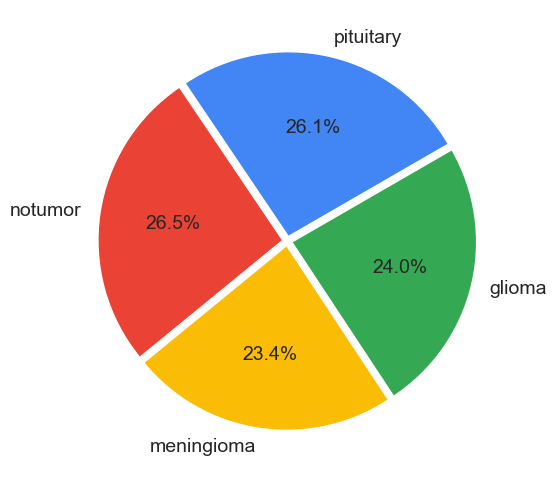

In [3]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels_type if x == 'pituitary']),
         len([x for x in train_labels_type if x == 'notumor']),
         len([x for x in train_labels_type if x == 'meningioma']),
         len([x for x in train_labels_type if x == 'glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

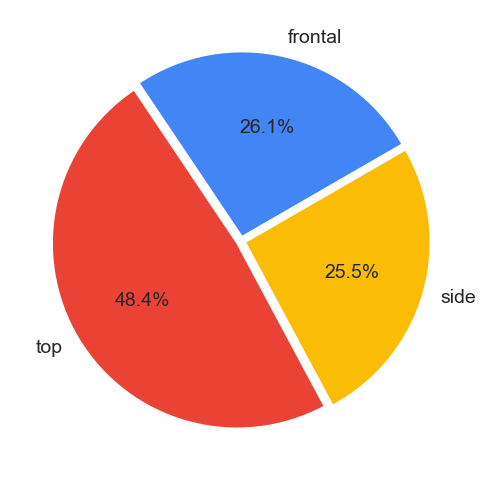

In [4]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels_position if x == 'frontal']),
         len([x for x in train_labels_position if x == 'top']),
         len([x for x in train_labels_position if x == 'side'])],
        labels=['frontal','top', 'side'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025),
        startangle=30);

In [5]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

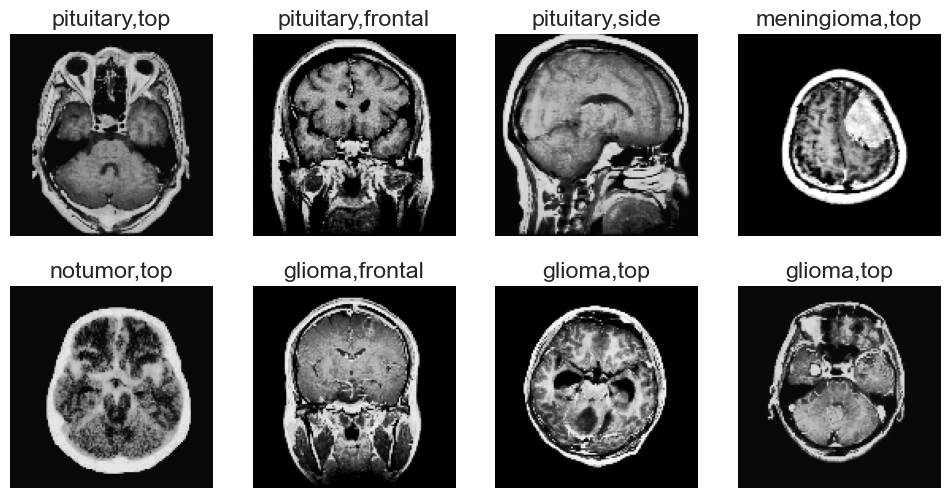

In [6]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels_type[50:59]
positions = train_labels_position[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x]+','+positions[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

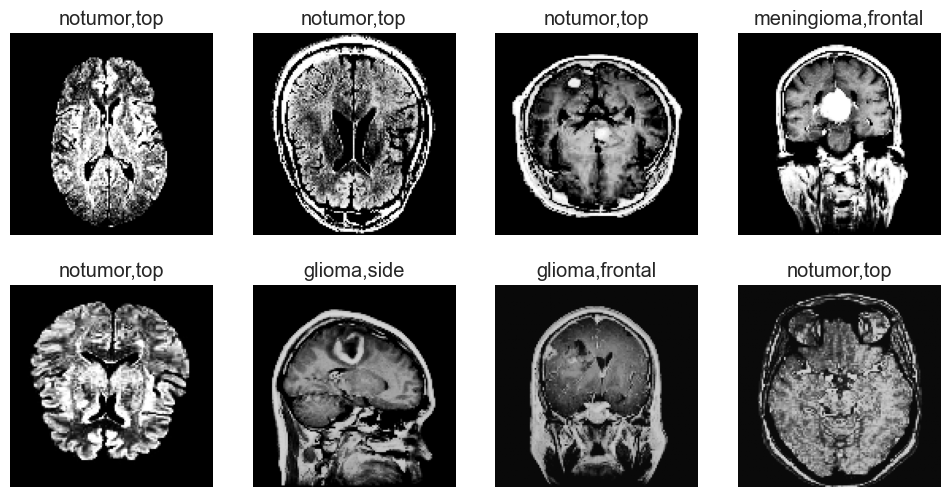

In [7]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(test_paths[50:59])
labels = test_labels_type[50:59]
positions = test_labels_position[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x]+','+positions[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [8]:
unique_labels = os.listdir(train_dir)

print(unique_labels)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

['glioma', 'meningioma', 'notumor', 'pituitary']


In [9]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

In [11]:
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin"
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [13]:
batch_size = 25
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels_type, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
218/218 [==============================] - 1069s 5s/step - loss: 0.4260 - sparse_categorical_accuracy: 0.8422
Epoch 2/10
218/218 [==============================] - 935s 4s/step - loss: 0.1991 - sparse_categorical_accuracy: 0.9271
Epoch 3/10
218/218 [==============================] - 915s 4s/step - loss: 0.1335 - sparse_categorical_accuracy: 0.9501
Epoch 4/10
218/218 [==============================] - 927s 4s/step - loss: 0.1030 - sparse_categorical_accuracy: 0.9616
Epoch 5/10
218/218 [==============================] - 915s 4s/step - loss: 0.0788 - sparse_categorical_accuracy: 0.9727
Epoch 6/10
218/218 [==============================] - 915s 4s/step - loss: 0.0624 - sparse_categorical_accuracy: 0.9778
Epoch 7/10
218/218 [==============================] - 908s 4s/step - loss: 0.0410 - sparse_categorical_accuracy: 0.9840
Epoch 8/10
218/218 [==============================] - 912s 4s/step - loss: 0.0366 - sparse_categorical_accuracy: 0.9875
Epoch 9/10
218/218 [===================

In [14]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels_type, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/38 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


  3%|▎         | 1/38 [00:17<10:39, 17.29s/it]

1/1 [==============================] - 6s 6s/step


  5%|▌         | 2/38 [00:26<07:34, 12.62s/it]

1/1 [==============================] - 3s 3s/step


  8%|▊         | 3/38 [00:30<05:06,  8.75s/it]

1/1 [==============================] - 3s 3s/step


 11%|█         | 4/38 [00:35<03:57,  6.99s/it]

1/1 [==============================] - 3s 3s/step


 13%|█▎        | 5/38 [00:39<03:18,  6.01s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 6/38 [00:43<02:52,  5.40s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 7/38 [00:47<02:35,  5.03s/it]

1/1 [==============================] - 4s 4s/step


 21%|██        | 8/38 [00:52<02:25,  4.86s/it]

1/1 [==============================] - 4s 4s/step


 24%|██▎       | 9/38 [00:56<02:16,  4.72s/it]

1/1 [==============================] - 4s 4s/step


 26%|██▋       | 10/38 [01:01<02:10,  4.64s/it]

1/1 [==============================] - 4s 4s/step


 29%|██▉       | 11/38 [01:05<02:05,  4.65s/it]

1/1 [==============================] - 4s 4s/step


 32%|███▏      | 12/38 [01:10<02:00,  4.62s/it]

1/1 [==============================] - 4s 4s/step


 34%|███▍      | 13/38 [01:15<01:56,  4.66s/it]

1/1 [==============================] - 4s 4s/step


 37%|███▋      | 14/38 [01:19<01:50,  4.62s/it]

1/1 [==============================] - 4s 4s/step


 39%|███▉      | 15/38 [01:24<01:45,  4.59s/it]

1/1 [==============================] - 4s 4s/step


 42%|████▏     | 16/38 [01:28<01:39,  4.53s/it]

1/1 [==============================] - 4s 4s/step


 45%|████▍     | 17/38 [01:33<01:35,  4.54s/it]

1/1 [==============================] - 4s 4s/step


 47%|████▋     | 18/38 [01:37<01:30,  4.54s/it]

1/1 [==============================] - 4s 4s/step


 50%|█████     | 19/38 [01:42<01:26,  4.53s/it]

1/1 [==============================] - 4s 4s/step


 53%|█████▎    | 20/38 [01:46<01:22,  4.57s/it]

1/1 [==============================] - 4s 4s/step


 55%|█████▌    | 21/38 [01:52<01:21,  4.77s/it]

1/1 [==============================] - 4s 4s/step


 58%|█████▊    | 22/38 [01:56<01:16,  4.77s/it]

1/1 [==============================] - 4s 4s/step


 61%|██████    | 23/38 [02:01<01:11,  4.77s/it]

1/1 [==============================] - 4s 4s/step


 63%|██████▎   | 24/38 [02:06<01:06,  4.73s/it]

1/1 [==============================] - 4s 4s/step


 66%|██████▌   | 25/38 [02:11<01:01,  4.73s/it]

1/1 [==============================] - 4s 4s/step


 68%|██████▊   | 26/38 [02:15<00:56,  4.74s/it]

1/1 [==============================] - 4s 4s/step


 71%|███████   | 27/38 [02:20<00:53,  4.85s/it]

1/1 [==============================] - 4s 4s/step


 74%|███████▎  | 28/38 [02:25<00:48,  4.90s/it]

1/1 [==============================] - 4s 4s/step


 76%|███████▋  | 29/38 [02:30<00:43,  4.89s/it]

1/1 [==============================] - 5s 5s/step


 79%|███████▉  | 30/38 [02:36<00:40,  5.01s/it]

1/1 [==============================] - 5s 5s/step


 82%|████████▏ | 31/38 [02:41<00:36,  5.23s/it]

1/1 [==============================] - 4s 4s/step


 84%|████████▍ | 32/38 [02:47<00:31,  5.27s/it]

1/1 [==============================] - 5s 5s/step


 87%|████████▋ | 33/38 [02:52<00:27,  5.42s/it]

1/1 [==============================] - 10s 10s/step


 89%|████████▉ | 34/38 [03:08<00:33,  8.41s/it]

1/1 [==============================] - 7s 7s/step


 92%|█████████▏| 35/38 [03:18<00:26,  8.96s/it]

1/1 [==============================] - 4s 4s/step


 95%|█████████▍| 36/38 [03:23<00:15,  7.73s/it]

1/1 [==============================] - 4s 4s/step


 97%|█████████▋| 37/38 [03:28<00:06,  6.83s/it]

1/1 [==============================] - 4s 4s/step


100%|██████████| 38/38 [03:33<00:00,  6.24s/it]

1/1 [==============================] - 2s 2s/step


39it [03:35,  5.52s/it]                        


In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.97      0.97      0.97       298
  meningioma       0.93      0.96      0.95       263
     notumor       1.00      0.99      1.00       372
   pituitary       0.99      0.97      0.98       288

    accuracy                           0.97      1221
   macro avg       0.97      0.97      0.97      1221
weighted avg       0.97      0.97      0.97      1221
